<font color="#84567D"> Author: Mahmud Hasan  </font>  <br>

License : MIT


<div class="alert alert-block alert-success">
    <title>
    <h2>Notebook Title: Sea level rising trend  in the Mediterranean Sea </h2>
    </title>
    <body bgcolor="black"> 
    
    Background : Due to the rapid pace of global warming, sea-level rising trend is higher than pervious decades and it's one of the concerned issues to the scientists and researchers. It's important to observe this trend continously and assess the vulnerablity in the coastal areas, particularly in an enlcosed sea like in the Mediterranean Sea. Through this approach, I present a simple overview of the sea-level rising trend that end users can easily follow the curent scenario in the Mediterranean Seae. 
   </body>

Dataset : Sea level anomaly daily gridded data retrieved from satellite altimetry products </br>
Data source : Wekeo
 
<a id='TOC_TOP'></a>
<h3>Contents </h3>


* [Python packages](#python_packages)

* [Data reading and masking](#Data_reading_masking)

* [Defined Functions](#functions)

* [SLA trend analysis](#SLA+trend+analysis) 

* [Visualization](#plotting)
    -> [Plot 1](#plot1)
    -> [Plot 2](#plot2)
    -> [Plot 3](#plot3)
    -> [Plot 4](#plot4)
    -> [Plot 5](#plot5)

[Back to top](#TOC_TOp)

<a id='python_packages'></a>
Python packages 

In [4]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import warnings
from mpl_toolkits.basemap import Basemap
import xarray as xr
import scipy 
from scipy import stats
from hda import Client  
import json
import zipfile
from scipy import signal 
from eofs.standard import Eof

In [1]:
# Create a download directory for the target dataset 
download_dir = os.path.join(os.getcwd(), "sla_dir")
#os.makedirs(download_dir, exist_ok=True)


[Back to top](#TOC_TOP)
<a id='Data_reading_masking'></a>
</br>
<h4>SLA dataset reading, masking and seapoints for time series analysis </h4>

In [96]:
# ralative path, change according to system/PC 

path ="/Volumes/LaCie_poseidone/sla_93-20/"

#files_dir= os.path.join(path)
files= (path+"*.nc")
fl_list= glob.glob(path+"*.nc")
## Reading single file and retrieve lat , lon values
file =xr.open_dataset(fl_list[0])
lat = file.variables["latitude"][:]
lon =file.variables["longitude"][:]
time = file["time"]
nlat= len(lat)
nlon = len(lon)

# target vairables specification 
sla= file["sla"][:]
ugva = file["ugosa"][:]   # geotropic velocity anomalies U- zonal component
vgva =file["vgosa"][:]  # geotropic velocity anomalies :V-meridonial component 

sla_files=xr.open_mfdataset(files,combine='nested',parallel=True, concat_dim= ['time'])
sla_series=sla_files["sla"][:]

## masking land point 
sla_series=np.nan_to_num(sla_series)   #
sla_mask = np.ma.masked_where(sla_series==0, sla_series) # by deafult np.nan_to_num transforms land points to 0  


## Finding  sea point indices in model grids
#- Western Mediterranean 
alb= [-3.7, 36.05]  # Alboran sea  location
lion=[ 5.1, 41.6]   # Gulf of Lion locaiton
tyr = [12.1, 39.5]  #  Tyrrhenian Sea location
sic = [12.0, 36.5]  # Scility strait locaiton 
#- Eastern Mediterrnean 
adr= [18, 41.7]    # Adriatic ne location
agean = [24.8, 36.2] #Agean sea new locaiton
ionian= [18.7,36.7] # Iionnian ea new locaiton
levantine= [32.8, 33.2] # Levantine sea new locaiton
  

# creating figs directory 
rdir="/Users/mahmud/statistics/plot_exercises/sla_dir/"  #root dir, change according to PC path 
analysis = rdir + "sla_analysis/"
if not os.path.isdir(analysis):
    os.mkdir(analysis)


[Back to top](#TOC_TOP)
<a id='functions'></a>

<h4>Defined functions for the analysis </h4>

In [76]:
# 1: Function for finding single grid point from lat an lon series
def single_grid(lati,long,loc):
    loc_ln = np.where(long>loc[0])[0]
    loc_lt = np.where(lati>loc[1])[0]
    loc_grid=[loc_ln[0],loc_lt[0]]
    return loc_grid

# 2: Function for retrieving single location values from the target variable
def sgrid_values(series, list1, list2):
    loc_val = []
    for i in range(2):
        sl_value = series[:,list1[i],list2[i]]
        loc_val.append(sl_value)
    return loc_val

# 3: Function for computing surface monthly mean
yr_d1= pd.date_range(start='1993-01-01',end= '2020-01-01',freq='YS')
yr_d365= pd.date_range(start='1993-12-31',end= '2020-06-03',freq='Y')

def surface_monthly_mean(xarr): 
    monwise_mean= []
    idx=0
    for i in range(27):
        yr_slice=xarr.sel(time=slice(yr_d1[i],yr_d365[i]) )
        #yr_slice=xr.DataArray(yr_slice,dims=['time','lat','lon'])
        months_mean=yr_slice.groupby('time.month').mean('time')
        monwise_mean.append(months_mean)
        i+=1
    surf_mmn_series= np.concatenate(monwise_mean, axis=0)
    return surf_mmn_series

# 4: Function for computing surface yearly mean
def surface_yrly_mean(xarr):
    yrwise_mean= []
    idx=0
    for i in range(27):
        yrs_slice=xarr.sel(time=slice(yr_d1[i],yr_d365[i]) )
        #yr_slice=xr.DataArray(yr_slice,dims=['time','lat','lon'])
        yrs_mean=yrs_slice.groupby('time.year').mean('time')
        yrwise_mean.append(yrs_mean)
        i+=1
    surf_yrmn_series= np.concatenate(yrwise_mean, axis=0)
    return surf_yrmn_series 

# 5: Function for plot SLA mean and trend mean
def plot_sla(xarr, lon, lat, cmap=plt.get_cmap("jet"), ax=False, title=False):
    
    fig=plt.figure(figsize=(12,6))
    ax= fig.add_subplot(111)

    m= Basemap(projection='cyl', resolution='l',llcrnrlat= 30,urcrnrlat= 46, llcrnrlon= -6.0, urcrnrlon = 36.4, ax=ax)
    m.drawcoastlines(linewidth=1)
    m.drawparallels(range(30,48,5), linewidth=0, dashes=[0, 1], labels=[1,0,0,1], color='r', zorder=0 )
    m.drawmeridians(range(-5, 36, 7), linewidth=1, dashes=[0, 1], labels= [1,0,0,1])
    m.fillcontinents(alpha=0.9)
    m.drawlsmask(land_color='0.7', ocean_color='w', resolution='l', grid=5, lsmask_lons=None )
    cb= plt.pcolor(lon,lat,xarr[:,:], cmap="jet")
    plt.colorbar(cb,orientation ="vertical", shrink =0.64, aspect=11.5, pad=0.05)
    if title:
        ax.set_title(title, size =14)



<a id='section1'></a>
[Back to top](#TOC_TOP)

SLA trend analysis 

In [9]:
#--Single grid location values with pre-defined functions 

alb_loc=single_grid(lat,lon, alb)             #Alboran sea
lione_loc= single_grid(lat, lon, lion)        # Gulf of Lione

agean_loc=single_grid(lat,lon, agean)         # Agean Sea
levan_loc= single_grid(lat, lon, levantine)   # Levantine Sea

lon_list1 =list([alb_loc[0],lione_loc[0]])
lat_list1=list([alb_loc[1], lione_loc[1]])
lon_list2 =list([ agean_loc[0],levan_loc[0]])
lat_list2=list([agean_loc[1],levan_loc[1]])

west=sgrid_values(sla_series,lat_list1, lon_list1)
east=sgrid_values(sla_series, lat_list2, lon_list2)

#--SLA trend analysis using scipy packages 

dtrend= np.zeros((sla_mask.shape))

dtrend[:,:,:]= signal.detrend(sla_mask[:,:,:],axis=0, type='linear')

sla_trend= sla_mask[:,:,:]-dtrend[:,:,:]

%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 16 µs


[Back to top](#TOC_TOP)
<a id='plotting'></a>
<h3>Plotting section for  SLA data analyses </h3>

<a id='plot1'></a>
[Back to top](#TOC_TOP)

Plot-1: Mean SLA for the period 1993-2020

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


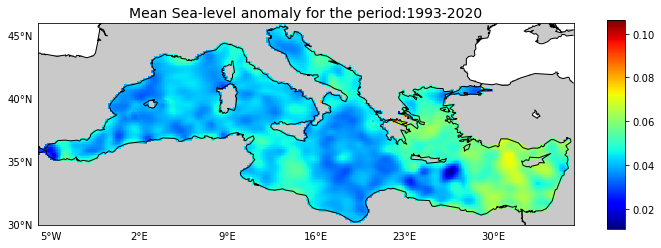

In [81]:

sla_mean= np.mean(sla_mask, axis=0)
plot_sla( sla_mean, lon, lat, title=("Mean Sea-level anomaly for the period:1993-2020"))
%time     
#plt.savefig(analysis+"sla_mean_1993.2020.jpeg",dpi=100)

<a id='plot2'></a>
[Back to top](#TOC_TOP)

Plot 2: Time series analysis with sea level rising trend in the Mediterranean Sea(MedSea)

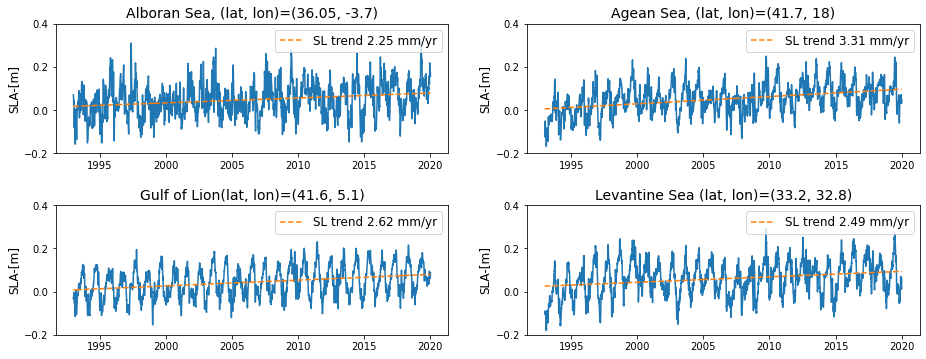

In [279]:

sea1 = ["Alboran Sea, ","Gulf of Lion"]    #Easter MedSea
sea2=  [ "Agean Sea, ", "Levantine Sea "]  # Western MedSea
sea1_locs = [alb, lion]
sea2_locs=  [adr, levantine]


west_trend=sgrid_values(sla_trend,lat_list1, lon_list1)
east_trend=sgrid_values(sla_trend,lat_list2, lon_list2)

alb_trend=(((west_trend[0][-1]- west_trend[0][0])/10016)*365)*1000
lione_trend= (((west_trend[1][-1]-west_trend[1][0])/10016)*365)*1000
agean_trend=(((east_trend[0][-1]- east_trend[0][0])/10016)*365)*1000
levan_trend= (((east_trend[1][-1]- east_trend[1][0])/10016)*365)*1000

west_trnd_rate= np.array([alb_trend, lione_trend])
east_trnd_rate= np.array([agean_trend, levan_trend])

fig,ax =plt.subplots(2,2,figsize=(15,6))
yr=np.linspace(1993, 2020, 10016)

for iplot in range(2):
    for zplot in range(2):    

        if zplot==0:
            ax[iplot][zplot].plot(yr, west[iplot] ) 
            #ax1[1].plot(yr, sla_list[1]) 
            ax[iplot][zplot].plot(yr, west_trend[iplot], '--', label="SL trend "+"{:.2f}".format(west_trnd_rate[iplot])+ " mm/yr") 
            ax[iplot][zplot].set_title(sea1[iplot]+ "(lat, lon)=("+str(sea1_locs[iplot][1])+", "+str(sea1_locs[iplot][0])+")", fontsize=14) 
            #ax[iplot][zplot].set_xlabel(plot_info[0], size='13')
            ax[iplot][zplot].set_ylim(-0.2, 0.4)  

        if zplot==1:
          
            ax[iplot][zplot].plot(yr, east[iplot])
            ax[iplot][zplot].plot(yr, east_trend[iplot],'--', label="SL trend "+"{:.2f}".format(east_trnd_rate[iplot])+ " mm/yr")
            r_range=[-0.2, 0.4]
            ax[iplot][zplot].set_title(sea2[iplot]+ "(lat, lon)=("+str(sea2_locs[iplot][1])+", "+str(sea2_locs[iplot][0])+")", fontsize=14)
#             ax[iplot][zplot].set_xlabel(plot_info[0], size='13')
            ax[iplot][zplot].set_ylim(r_range[0], r_range[1])
             
        ax[iplot][zplot].legend(facecolor='inherit', fontsize=12, loc="upper right")
        ax[iplot][zplot].set_ylabel("SLA-[m]", size ='12' )

    plt.subplots_adjust(left=0.11, bottom=0.08, right=0.91, top=0.80, wspace=0.2, hspace=0.4)

plt.savefig(analysis+"time_series_trend_1993.2020.jpeg",dpi=100)

<a id='plot3'></a>
[Back to top](#TOC_TOP)

Plot 3- Mean sea level trend for the observed period in the MedSea 

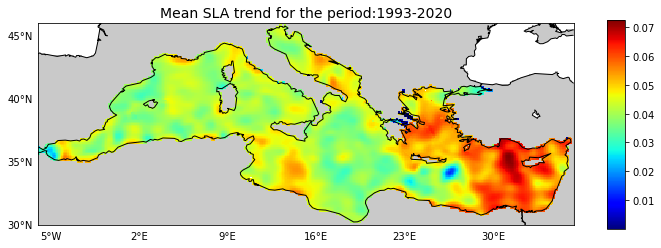

In [87]:
sla_trend_icept = sla_trend[0,:,:]  # INtercept 
sla_trend_slp= sla_trend[1,:,:,]-sla_trend[0,:,:]  ##.  Slope

sla_trend_mean= np.mean(sla_trend, axis=0) 
plot_sla(sla_trend_mean,lon,lat,  title="Mean SLA trend for the period:1993-2020")

#plt.savefig(analysis+"sla_mean_trend_1993_2020.jpeg",dpi=100)

<a id='plot4'></a>
[Back to top](#TOC_TOP)

Plot4 - SLA trend analysis plot for the whole MedSea basin

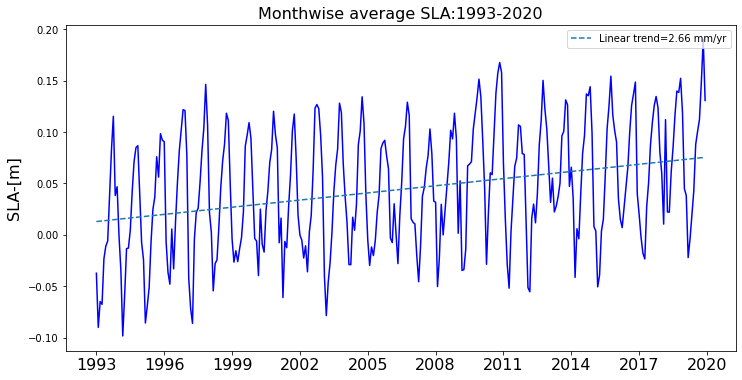

In [281]:

dt=pd.date_range(start='1993-01-01', end='2020-06-03',freq='D')
sla_mask=xr.DataArray(sla_mask,dims=['time','lat','lon'], coords= dict(time=dt))
sla_trend=xr.DataArray(sla_trend,dims=['time','lat','lon'], coords= dict(time=dt))


sla_surf_mean= np.mean(sla_mask, axis= (1,2))

sla_surf_mm=surface_monthly_mean(sla_surf_mean)   # surface/basin averaged month-wise mean 
sla_mon_mn=np.repeat((np.average(sla_surf_mm)),360)  # surface/basin averaged SLA 

sla_trend_surfmn =np.mean(sla_trend, axis=(1,2))
sla_tr_sfmn_mon= surface_monthly_mean(sla_trend_surfmn)   # monthwise trend values for 27 yrs


sla_yrs_mn = surface_yrly_mean(sla_surf_mean)
sla_rate= ((sla_yrs_mn[-1]-sla_yrs_mn[0])/27)*1000  

# -- yearly time series for x -axis
xdata= np.arange(0,(2020-1993+1)*12,12*3 )
xlabels= np.arange(1993, 2020+1, 3)

# ---plotting of surface monthly mean
fig,axs=plt.subplots(1,1,figsize=(12,6))
#plt.sca(axs[1,1])
plt.plot( sla_surf_mm,'-b', label="")
plt.plot(sla_tr_sfmn_mon,'--', label="Linear trend="+ "{:.2f}".format(sla_rate)+ " mm/yr")

plt.title("Monthwise average SLA:1993-2020",fontsize=16)
plt.legend(facecolor='inherit', fontsize=10, loc="upper right")
plt.ylabel("SLA-[m]",fontsize=16,labelpad= 6)
plt.xticks(xdata,xlabels)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='minor', labelsize=22)
#plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(analysis+"monthy_avg_trend_1993_2020.jpeg",dpi=100)

<a id='plot5'></a>
[Back to top](#TOC_TOP)

Plot-5 Spatial-temporal variation with EOF/PC analysis 

In [83]:
lat_val=lat.values
lons, lats= np.meshgrid(lon, lat)

# creating Weighted array 
coslat= np.cos(np.deg2rad(lat_val))
wgts = np.sqrt(coslat)[..., np.newaxis]

# EOF computation 
eof_solv= Eof(sla_mask, weights=wgts)
eof_n= eof_solv.eofsAsCorrelation(neofs=3)

In [283]:
# principal components(PCs with normalization )
pcm= eof_solv.pcs(npcs=3, pcscaling=1)
pcm_df= pd.DataFrame(pcm, index=sla_files['time'], columns=['EOF%s' % (x) for x in range(1, pcm.shape[1]+1)])
pcm_array=np.array(pcm_df)

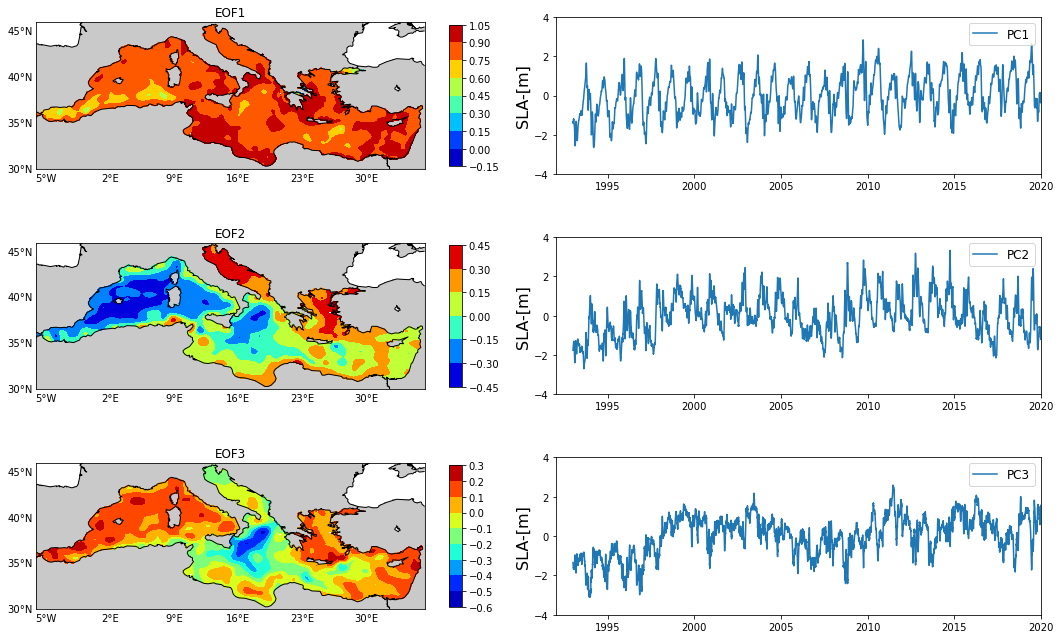

In [353]:
fig,ax =plt.subplots(3,2,figsize=(18,11))
yr=np.linspace(1993, 2020, 10016)

for iplot in range(3):
    for zplot in range(2):  
        
        if zplot==0:
            
            m= Basemap(projection='cyl', resolution='l',llcrnrlat= 30,urcrnrlat= 46, llcrnrlon= -6.0, urcrnrlon = 36.4, ax=ax[iplot][zplot])
            m.drawcoastlines(linewidth=1)
            m.drawparallels(range(30,48,5), linewidth=0, dashes=[0, 1], labels=[1,0,0,1], color='r', zorder=0 )
            m.drawmeridians(range(-5, 36, 7), linewidth=1, dashes=[0, 1], labels= [1,0,0,1])
            m.fillcontinents(alpha=0.9)
            m.drawlsmask(land_color='0.7', ocean_color='w', resolution='l', grid=5, lsmask_lons=None )
            cb=ax[iplot][zplot].contourf(lons,(lats),eof_n[iplot,:,:].squeeze(), cmap="jet")  #√levels=np.arange(-1, 1, 0.1)
            plt.colorbar(cb, ax=ax[iplot][zplot], orientation ="vertical", shrink =0.9, aspect=11, pad=0.05)
            titles= ["EOF1", "EOF2", "EOF3"]
            ax[iplot][zplot].set_title(titles[iplot])  
            #plt.title("EOF-1",fontsize=16)

        if zplot==1:
            level= ["PC1", "PC2", "PC3"]
            ax[iplot][zplot].plot(yr,pcm_array[:,iplot], label=level[iplot])
            ax[iplot][zplot].set_ylim(-4, 4)
            ax[iplot][zplot].set_xlim(1992, 2020)
            ax[iplot][zplot].legend(facecolor='inherit', fontsize=12, loc="upper right")
            ax[iplot][zplot].set_ylabel("SLA-[m]",fontsize=16,labelpad=3)
        fig.subplots_adjust(hspace =0.4, wspace=0.07)

plt.savefig(analysis+"EOF_PCs_1993_2020.jpeg",dpi=100)